# Clustering (Vectorize and then Cluster with Word2Vec)

In [61]:
# imports

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

from gensim import corpora, models, similarities, matutils
from sklearn.cluster import KMeans, DBSCAN
import os

In [2]:
# Read in data
corpus = pd.read_pickle('../preprocessing/cleaned_data.pkl')
corpus.shape

(42234, 1)

In [3]:
# Check it out
corpus.head(5)

,cleaned_title
0,bacon lollipops bell eccentric cafe grand rapi...
1,pico gallo spend pennies
2,dinner elizabeth chop marquette mi
3,artisanal mezcal celebrate cinco mayo
4,veggie eggie er veggie


## Vectorize the words with Google's Word2Vec

In [4]:
# load google's word2vec

google_vec_file = '/Users/danielwilentz/Downloads/GoogleNews-vectors-negative300.bin'
w2v = models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [5]:
# save it

w2v.save('../models/word2vec.model')

In [6]:
# check the length

len(w2v.vocab)

3000000

In [7]:
# Get my documents as vectors according to word2vec

vectors = []
count = 0
not_in_vocab = 0
for index, document in corpus.iterrows():
    vec = np.zeros(300)
    for word in document['cleaned_title'].split():
        try:
            vec += w2v[word]
        except KeyError:
            not_in_vocab += 1
    vectors.append(vec/len(document['cleaned_title'].split()))
    count += 1

print(not_in_vocab)

11020


In [8]:
# Prepare DF for modeling
df_for_modeling = pd.DataFrame(vectors)

In [9]:
# Check shape
df_for_modeling.shape

(42234, 300)

## Clustering with K-Means

### Picking the optimal number of clusters

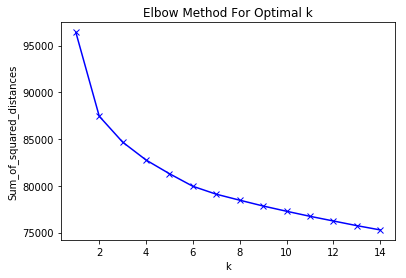

In [12]:
# We csn also generate an elbow plot to see what number of clusters is best using inertia
# This cell takes a while to run!
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_for_modeling)
    Sum_of_squared_distances.append(km.inertia_)

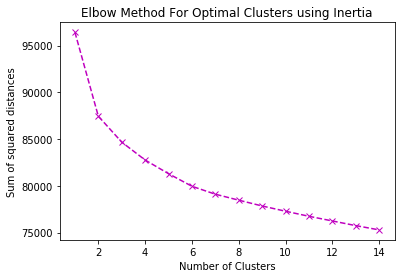

In [57]:
# Plot the inertia scores

plt.plot(K, Sum_of_squared_distances, 'mx--')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal Clusters using Inertia')
plt.show()

In [22]:
# Let's do the same thing as above except with silhouette score

scores = []
cluster_count = []
for i in range(2,29,1):
    print(i)
    km = KMeans(n_clusters=i)
    km.fit(df_for_modeling)
    pred =km.predict(df_for_modeling)
    scores.append(silhouette_score(df_for_modeling, pred))
    cluster_count.append(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [69]:
font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rcdefaults()
matplotlib.rc('font', **font)

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


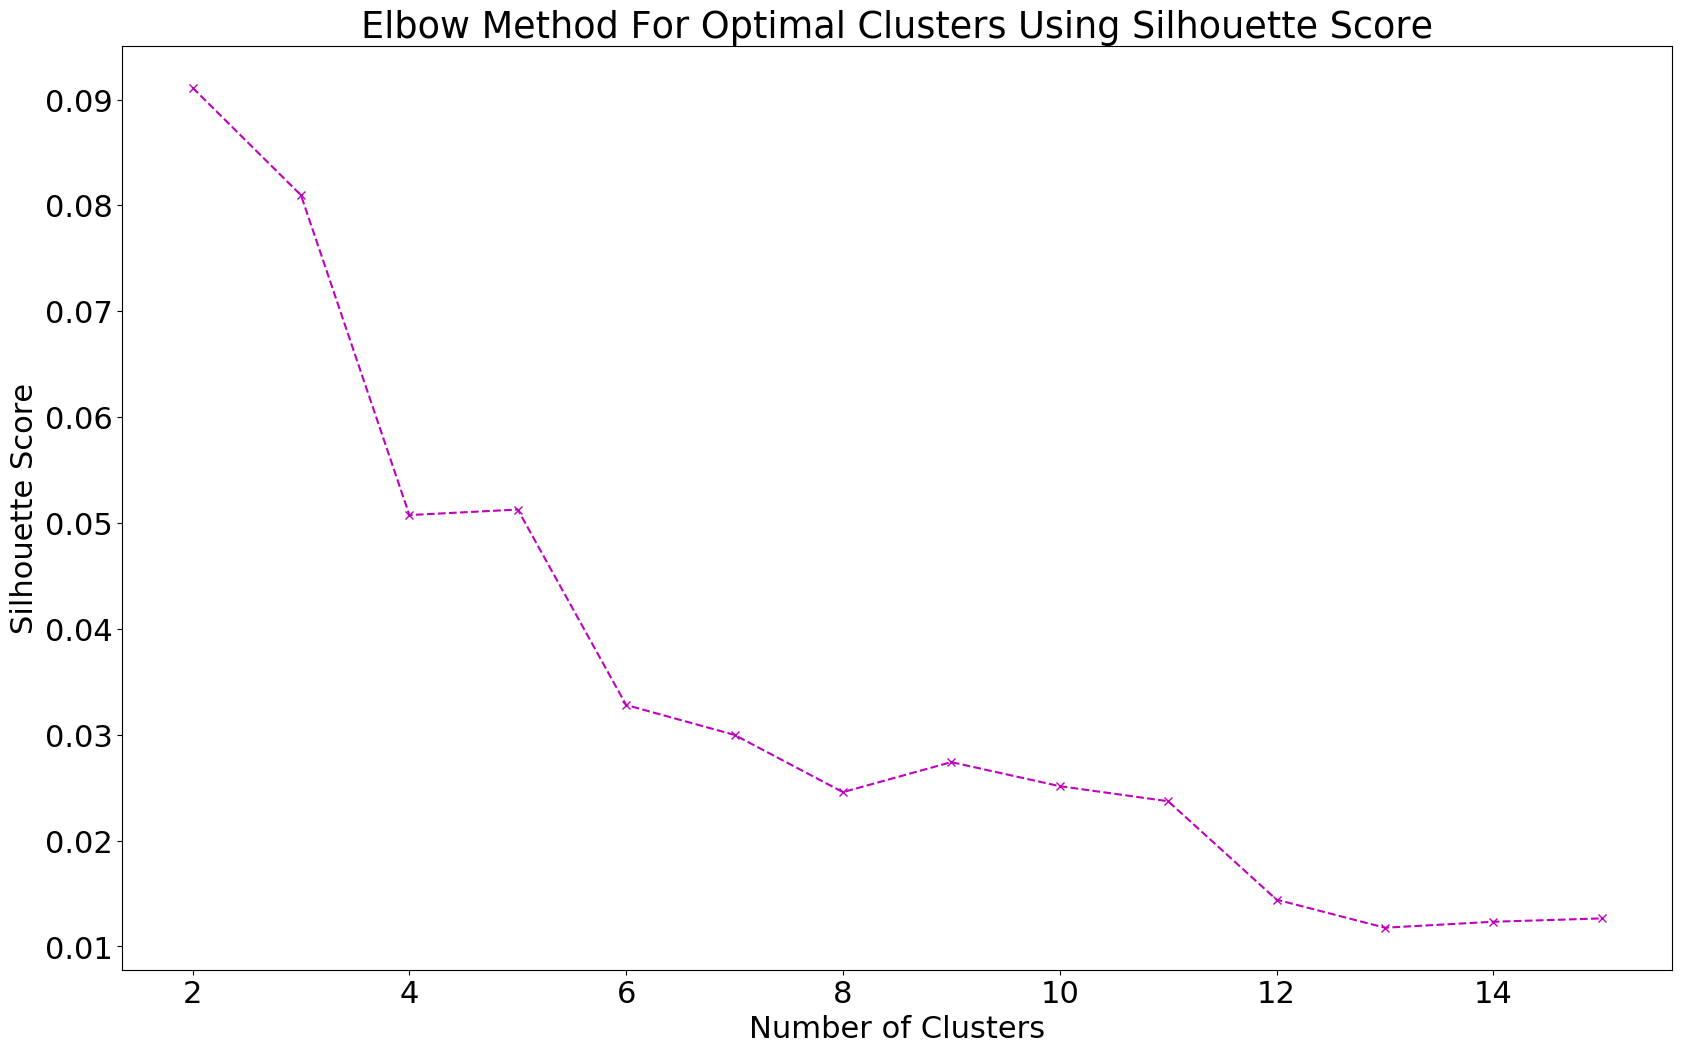

In [70]:
# Plot the silhouette scores
plt.figure(figsize=(20,12))
plt.plot(cluster_count[:14], scores[:14], 'mx--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method For Optimal Clusters Using Silhouette Score')
plt.savefig('../figures/scree_kmeans.png', dpi=200)

Looks like 5-6 topics is a good choice after all!

In [25]:
# Do a final clustering with 6 clusters, as this number pops up in my LSA scree, my silhouette score plot, and
# my inertia score plot

num_clusters = 6
km6 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=10, n_init=1) 
km6.fit(df_for_modeling)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [55]:
# Add clusters as a label to the data we are working with
km6.labels_

array([5, 5, 5, ..., 4, 0, 1], dtype=int32)

In [45]:
# read the data with labels from topic modeling in
df_w_labels = pd.read_pickle('df_w_labels.pkl')

In [48]:
# Add the clusters from k-means
df_w_labels['clusters'] = km6.labels_

In [54]:
# check it out
df_w_labels.sample(10)

,cleaned_title,labels,clusters
16084,mac n cheese burger drunken bear youtube channel,Sandwich,5
944,facebook friends family lunch photo,Entree,4
33866,apple carrot soup,Entree,3
8286,eatily nyc dozen oysters dozen clams nom,Entree,5
13477,open faced breakfast sandwich,Burger,2
33273,peppers cheese stuffed pork bed mashed potatoe...,Sandwich,1
3860,bacon wrapped bbq cheese dogs bacon gouda mac ...,Burger,2
32213,turkey bacon avocado club plus easy egg,Burger,1
36480,caesar salad,Entree,0
31978,ms fai blog kyusinero grill restaurant camp ca...,Entree,5
